In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1) LOAD DATA
# ============================================================
df_bagerhat = pd.read_csv("Bagerhat_historical_weather_1980_2024.csv")

# ============================================================
# 2) BASIC INFO
# ============================================================
print(df_bagerhat.info())
print(df_bagerhat.head())

# ============================================================
# 3) COUNT TEMPERATURE & HUMIDITY DATA
# ============================================================
df_temp = df_bagerhat['temperature(degree C)'].count()
df_hum  = df_bagerhat['humidity'].count()

print(f"temperature(degree C) has : {df_temp}")
print(f"humidity has : {df_hum}")

# ============================================================
# 4) SELECT FEATURES FOR WET-BULB
# ============================================================
desired_columns = ['day', 'month', 'year', 'temperature(degree C)', 'humidity']
WB_df = df_bagerhat[desired_columns]

print(WB_df.head())

# ============================================================
# 5) DROP NULL VALUES
# ============================================================
with_no_null_WB = WB_df.dropna()
print(f"After removing missing values: {with_no_null_WB.shape}")

print(with_no_null_WB.head())

# ============================================================
# 6) CHECK & DROP ZEROES
# ============================================================
zeros_per_col = (with_no_null_WB == 0).sum()
zeros_df = zeros_per_col.to_frame("zero_count")
zeros_df["zero_percentage"] = (zeros_df["zero_count"] / len(with_no_null_WB) * 100).round(2)
zeros_df = zeros_df[zeros_df["zero_count"] > 0]
print(zeros_df)

before = with_no_null_WB.shape[0]
with_no_null_WB = with_no_null_WB[(with_no_null_WB != 0).all(axis=1)]
after = with_no_null_WB.shape[0]
print(f"Dropped {before-after} rows. New shape: {with_no_null_WB.shape}")

# ============================================================
# 7) CREATE DATE COLUMN
# ============================================================
with_no_null_WB['date'] = pd.to_datetime(with_no_null_WB[['year','month','day']])

print("Date range:", with_no_null_WB['date'].min(), "to", with_no_null_WB['date'].max())

wb_df['unsurvivable'] = wb_df['Tw'] >= 27.8
dangerous_days = wb_df[wb_df['unsurvivable']]

print(f"Number of unsurvivable days (Tw >= 27.8°C): {dangerous_days.shape[0]}")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   district                       16437 non-null  object 
 1   day                            16437 non-null  int64  
 2   month                          16437 non-null  int64  
 3   year                           16437 non-null  int64  
 4   temperature(degree C)          10478 non-null  float64
 5   feels_like(degree C)           10478 non-null  float64
 6   max_temperature(degree C)      14991 non-null  float64
 7   minimum_temperature(degree C)  14991 non-null  float64
 8   humidity                       10478 non-null  float64
 9   precipitation                  5479 non-null   float64
 10  windspeed                      11924 non-null  float64
 11  atmospheric_pressure           7115 non-null   float64
 12  UV                             4038 non-null  

NameError: name 'wb_df' is not defined

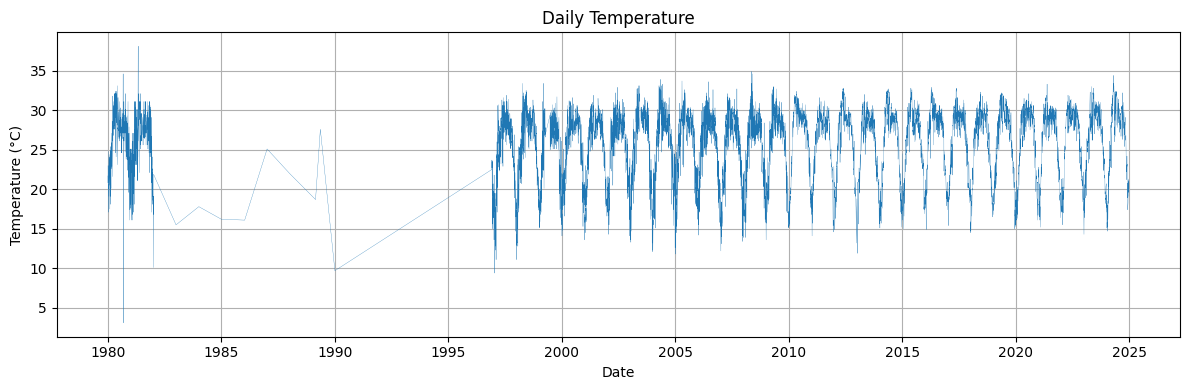

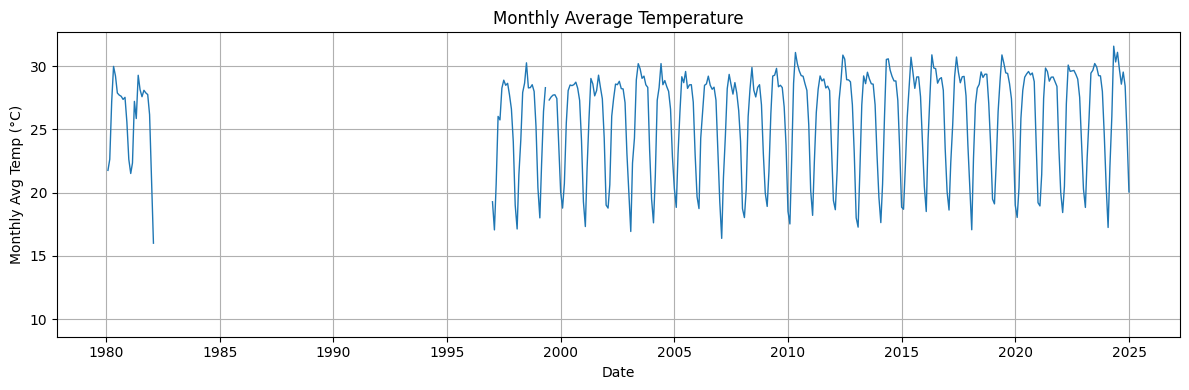

count    10478.000000
mean        23.407983
std          4.414779
min          2.990375
25%         19.901785
50%         25.362081
75%         26.983772
max         31.919478
Name: wet_bulb_C, dtype: float64
   day  month  year  temperature(degree C)  humidity       date  wet_bulb_C
0    1      1  1980                   21.7      77.1 1980-01-01   18.787098
1    2      1  1980                   20.8      64.4 1980-01-02   16.303332
2    3      1  1980                   23.0      60.2 1980-01-03   17.733379
3    4      1  1980                   22.3      70.4 1980-01-04   18.475789
4    5      1  1980                   22.1      67.8 1980-01-05   17.944936


In [ ]:
# ============================================================
# 8) TIME SERIES PLOT
# ============================================================
plt.figure(figsize=(12,4))
plt.plot(with_no_null_WB['date'], with_no_null_WB['temperature(degree C)'], linewidth=0.2)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daily Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

monthly_avg = with_no_null_WB.set_index('date')['temperature(degree C)'].resample('ME').mean()
plt.figure(figsize=(12,4))
plt.plot(monthly_avg.index, monthly_avg.values, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Monthly Avg Temp (°C)")
plt.title("Monthly Average Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 9) WET BULB TEMPERATURE FUNCTION (Stull, 2011)
# ============================================================
def wet_bulb_temp_C(T_c, RH):
    """
    Stull (2011) empirical wet-bulb temperature formula
    T in °C, RH in %
    """
    T = float(T_c)
    R = float(RH)

    Tw = T * np.arctan(0.151977 * np.sqrt(R + 8.313659)) \
         + np.arctan(T + R) - np.arctan(R - 1.676331) \
         + 0.00391838 * (R ** 1.5) * np.arctan(0.023101 * R) \
         - 4.686035

    return Tw

# ============================================================
# 10) COMPUTE WET BULB TEMPERATURE
# ============================================================
with_no_null_WB['wet_bulb_C'] = with_no_null_WB.apply(
    lambda r: wet_bulb_temp_C(r['temperature(degree C)'], r['humidity']),
    axis=1
)

print(with_no_null_WB['wet_bulb_C'].describe())
print(with_no_null_WB.head())

